# Eenergy Efficiency -- Integrated NLL "energy" vs β  +  Regularized PWC-β optimization (1→2→4→8)

[GMM] Added .sample(n, seed) method.


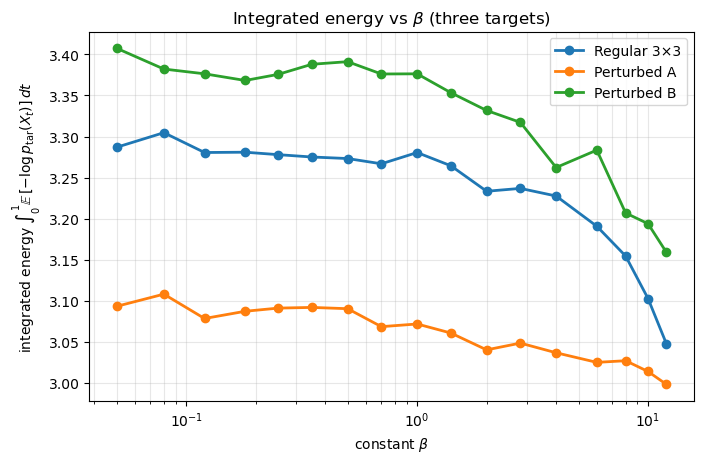

[saved] figs/integrated_vs_beta_three_models.png
[const best] Regular 3×3: β*≈12,  E≈3.048
[const best] Perturbed A: β*≈12,  E≈2.999
[const best] Perturbed B: β*≈12,  E≈3.159


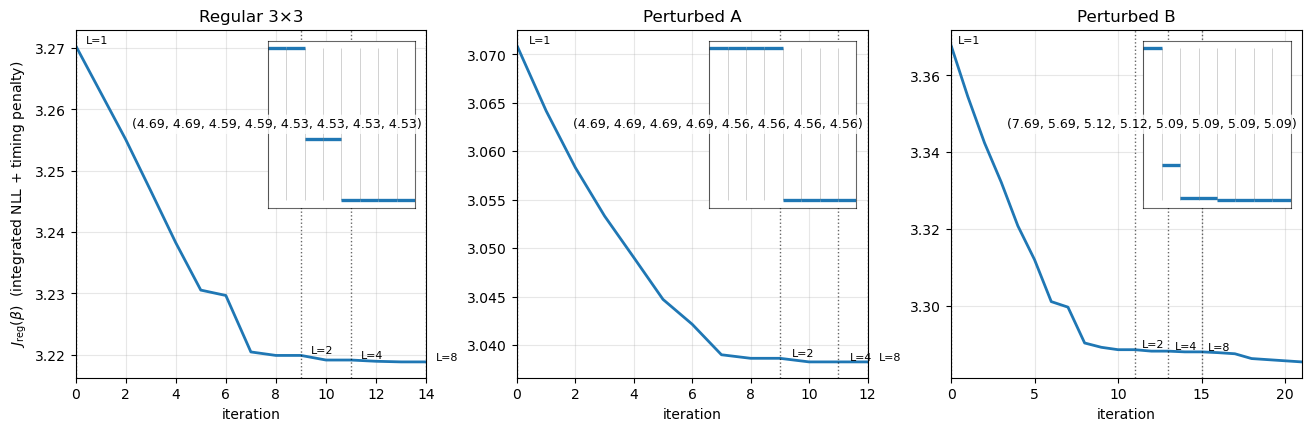

[saved] figs/integrated_convergence_three_subplots_inset.png


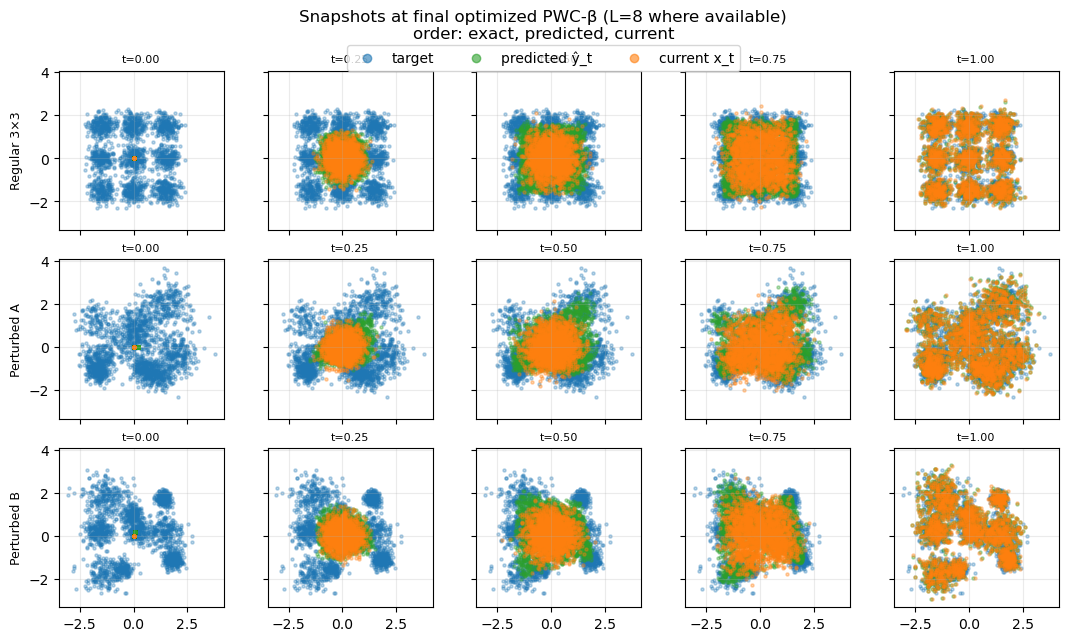

[saved] figs/integrated_snapshots_optimized_PWC.png
[Regular 3×3] final L=8:  t*≈0.523  (A*=0.5,  target t_trans=0.5)
[Perturbed A] final L=8:  t*≈0.497  (A*=0.5,  target t_trans=0.5)
[Perturbed B] final L=8:  t*≈0.523  (A*=0.5,  target t_trans=0.5)


In [1]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)


# ============================================================
# Integrated (NLL) "energy" vs β  +  Regularized PWC-β optimization (1→2→4→8)
# Energy:
#   J_E(β) = ∫_0^1 E[ -log p_tar(X_t) ] dt   (up to an additive constant)
#
# Regularized objective:
#   J_reg(β) = J_E(β) + λ_time * (max(0, t* - t_trans))^2,
#   where t* = first t with Ahat(t) ≥ A_star,  Ahat(t) = E[ ŷ(t;X_t)^T X_1 ] / E[ ||X_1||^2 ].
#
# Figures:
#   (A) Constant-β sweep of integrated NLL for three models
#   (B) Convergence per model (3 subplots, auto-scaled) with inset showing final β(t) (L=8)
#   (C) 3×5 snapshot grids at final optimized schedules (order: exact → predicted → current)
# ============================================================

import numpy as np, math, os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

os.makedirs("figs", exist_ok=True)

# ---------------------------- model builders ----------------------------
def build_regular_grid_gmm(a=1.5, sigma=0.3):
    xs = np.array([-a, 0.0, a], float)
    MU  = np.array([[xi, yj] for yj in xs for xi in xs], float)  # (9,2)
    SIG = np.full(9, float(sigma))
    PI  = np.ones(9, float)/9.0
    return GMM(MU, SIG, PI)

def build_perturbed_gmm(seed, a=1.5, base_sigma=0.3,
                        jitter_frac=1/3, sig_scale=(0.5, 2.0),
                        weight_range=(0.5, 1.5)):
    rng = np.random.default_rng(int(seed))
    xs = np.array([-a, 0.0, a], float)
    centers = np.array([[xi, yj] for yj in xs for xi in xs], float)  # (9,2)
    jitter_max = a * float(jitter_frac)
    MU  = centers + rng.uniform(-jitter_max, jitter_max, size=centers.shape)
    SIG = base_sigma * rng.uniform(sig_scale[0], sig_scale[1], size=9)  # per-comp σ_k > 0
    w   = rng.uniform(weight_range[0], weight_range[1], size=9)
    PI  = w / np.sum(w)
    return GMM(MU, SIG, PI)

# ---------------------------- schedule builder (robust to API flavors) ----------------------------
def make_pwc_schedule(splits, betas):
    splits = np.asarray(splits, float)
    betas  = np.asarray(betas, float)
    assert len(splits) == len(betas) + 1, "PWC requires len(splits)=len(betas)+1"
    assert np.all(np.diff(splits) > 0), "splits must be strictly increasing"
    tried = []
    for ctor in (
        lambda: BetaSchedulePWC.PWC(splits=splits, betas=betas),
        lambda: BetaSchedulePWC(betas=betas, splits=splits),
        lambda: BetaSchedulePWC.piecewise_constant(splits=splits, betas=betas),
    ):
        try:
            sched = ctor()
            # quick interior health probes
            for tp in (0.2, 0.5, 0.8):
                a, K, g = alpha_K_gamma_from_schedule(sched, float(tp))
                if not (np.isfinite(a) and np.isfinite(K) and K > 0 and np.isfinite(g) and g > 0):
                    raise RuntimeError("health probe failed")
            return sched
        except Exception as e:
            tried.append(repr(e))
    raise RuntimeError("Could not build PWC schedule.\n" + "\n".join(tried))

# ---------------------------- target energy: -log p_tar(x) (isotropic GMM) ----------------------------
def _logsumexp(a, axis=-1):
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

def gmm_neglogprob_iso(X, gmm):
    """
    Stable -log p_gmm(x) for isotropic components:
      p(x) = Σ_k π_k N(x | μ_k, σ_k^2 I)
    Returns shape (N,). Includes Gaussian normalization (additive const cancels across β anyway).
    """
    X = np.asarray(X, float)               # (N,d)
    MU  = np.asarray(gmm.MU, float)       # (K,d)
    SIG = np.asarray(gmm.SIG, float)      # (K,)
    PI  = np.asarray(gmm.PI, float)       # (K,)
    N, d = X.shape
    dx = X[:, None, :] - MU[None, :, :]   # (N,K,d)
    invs2 = 1.0 / (SIG**2)                # (K,)
    log_norm = -0.5 * d * np.log(2*np.pi*(SIG**2))  # (K,)
    sq = np.sum(dx*dx, axis=2)            # (N,K)
    log_comp = (np.log(PI)[None,:] + log_norm[None,:] - 0.5 * sq * invs2[None,:])  # (N,K)
    log_p = _logsumexp(log_comp, axis=1)  # (N,)
    return -log_p

# ---------------------------- simulator & objectives ----------------------------
def simulate_and_integrated_NLL(sched, gmm, *, M=1500, T=900, seed=0, t_low=0.01):
    """
    Midpoint EM, X(0)=0, unit diffusion. Returns ∫ E[-log p_tar(X_t)] dt.
    """
    rng = np.random.default_rng(seed)
    dt = 1.0 / T
    d  = gmm.d
    X  = np.zeros((M, d), float)
    accum = 0.0
    for n in range(T):
        t_mid = (n + 0.5)/T
        t_eff = min(max(t_mid, float(t_low)), 1.0 - float(t_low))
        yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m   = float(sched.a_minus(float(t_eff)))
        b_m   = float(sched.b_minus(float(t_eff)))
        u     = b_m * yhat - a_m * X
        # accumulate energy = E[-log p_tar(X_t)]
        nll = gmm_neglogprob_iso(X, gmm)              # (M,)
        accum += float(np.mean(nll)) * dt
        # advance
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW
    return float(accum)

def _Ahat_curve_and_tstar(sched, gmm, *, M=1200, T=800, seed=0, t_low=0.01,
                          N_eval=48, A_star=0.5):
    """
    Compute coarse curve of Ahat(t) and t* = first t where Ahat(t) ≥ A_star.
    Returns: (t_eval, Ahat, t_star or None)
    """
    rng = np.random.default_rng(seed)
    dt  = 1.0 / T
    d   = gmm.d
    X   = np.zeros((M, d), float)

    idx = np.linspace(0, T-1, int(min(max(4, N_eval), T))).round().astype(int)
    idx = np.unique(np.clip(idx, 0, T-1))
    t_eval = (idx + 0.5) / T
    idx_set = set(idx.tolist())

    Y_buf = None; k = 0
    for n in range(T):
        t_mid = (n + 0.5)/T
        t_eff = min(max(t_mid, float(t_low)), 1.0 - float(t_low))
        yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m   = float(sched.a_minus(float(t_eff)))
        b_m   = float(sched.b_minus(float(t_eff)))
        u     = b_m * yhat - a_m * X
        if n in idx_set:
            if Y_buf is None:
                Y_buf = np.empty((len(t_eval), M, d), float)
            Y_buf[k,:,:] = yhat; k += 1
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    denom = float(np.mean(np.sum(X*X, axis=1))) + 1e-30  # E||X_1||^2 proxy using terminal X
    Ahat = np.empty(k, float)
    for i in range(k):
        num = float(np.mean(np.sum(Y_buf[i]*X, axis=1)))
        Ahat[i] = num / denom

    t_star = None
    for ti, Ai in zip(t_eval[:k], Ahat):
        if Ai >= A_star:
            t_star = float(ti); break
    return t_eval[:k], Ahat, t_star

def objective_energy(betas, splits, gmm, *, M, T, seed, t_low):
    try:
        sched = make_pwc_schedule(splits, betas)
        for tp in (0.12, 0.36, 0.72, 0.9):
            a, K, g = alpha_K_gamma_from_schedule(sched, float(tp))
            if not (np.isfinite(a) and np.isfinite(K) and K > 0 and np.isfinite(g) and g > 0):
                return np.inf
        return simulate_and_integrated_NLL(sched, gmm, M=M, T=T, seed=seed, t_low=t_low)
    except Exception:
        return np.inf

def objective_energy_regularized(betas, splits, gmm, *,
                                 M, T, seed, t_low,
                                 N_eval=48, A_star=0.5, t_trans=0.5, lambda_time=0.5):
    """
    J_reg = Integrated NLL  +  λ_time * (max(0, t* - t_trans))^2
    """
    try:
        sched = make_pwc_schedule(splits, betas)
        for tp in (0.12, 0.36, 0.72, 0.9):
            a, K, g = alpha_K_gamma_from_schedule(sched, float(tp))
            if not (np.isfinite(a) and np.isfinite(K) and K > 0 and np.isfinite(g) and g > 0):
                return np.inf
        J_base = simulate_and_integrated_NLL(sched, gmm, M=M, T=T, seed=seed, t_low=t_low)
        _, Ahat, t_star = _Ahat_curve_and_tstar(sched, gmm, M=max(600,M//2), T=T, seed=seed+17,
                                                t_low=t_low, N_eval=N_eval, A_star=A_star)
        if t_star is None:
            t_star = 1.0
        penalty = lambda_time * max(0.0, t_star - float(t_trans))**2
        return float(J_base + penalty)
    except Exception:
        return np.inf

# ---------------------------- simple coordinate-descent (step halving) ----------------------------
def coord_descent_energy(
    betas0, splits, gmm, *, M, T, seed, t_low,
    use_regularizer=True, A_star=0.5, t_trans=0.5, lambda_time=0.5,
    step0=1.0, step_min=0.02, improve_tol=1e-3, max_sweeps=10,
    BETA_MIN=1e-3, BETA_MAX=12.0, record=None
):
    b = np.asarray(betas0, float).copy()
    if use_regularizer:
        fbest = objective_energy_regularized(b, splits, gmm, M=M, T=T, seed=seed, t_low=t_low,
                                             N_eval=48, A_star=A_star, t_trans=t_trans, lambda_time=lambda_time)
    else:
        fbest = objective_energy(b, splits, gmm, M=M, T=T, seed=seed, t_low=t_low)
    if record is not None: record.append(fbest)

    step = float(step0)
    for _ in range(max_sweeps):
        improved = False
        for k in range(len(b)):
            for sgn in (+1, -1):
                cand = b.copy()
                cand[k] = np.clip(cand[k] + sgn*step, BETA_MIN, BETA_MAX)
                if use_regularizer:
                    f = objective_energy_regularized(cand, splits, gmm, M=M, T=T, seed=seed, t_low=t_low,
                                                     N_eval=48, A_star=A_star, t_trans=t_trans, lambda_time=lambda_time)
                else:
                    f = objective_energy(cand, splits, gmm, M=M, T=T, seed=seed, t_low=t_low)
                if f + improve_tol < fbest:
                    b, fbest = cand, f
                    improved = True
                    if record is not None: record.append(fbest)
        if not improved:
            step *= 0.5
            if step < step_min:
                break
    return b, float(fbest)

# ---------------------------- constant-β sweep helper ----------------------------
def integrated_NLL_constbeta_curve(gmm_model, beta_grid, M=1500, T=900, seed=1234, t_low=0.01):
    vals = []
    for b in beta_grid:
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)
        vals.append(simulate_and_integrated_NLL(sched, gmm_model, M=M, T=T, seed=seed + int(31*b), t_low=t_low))
    return np.asarray(beta_grid, float), np.asarray(vals, float)

# ---------------------------- generic snapshot simulator ----------------------------
def simulate_snapshots_for_sched(sched, gmm, M=1800, T=1100, seed=0, N_cols=5, t_floor=0.01):
    rng  = np.random.default_rng(seed)
    dt   = 1.0 / T
    d    = gmm.d
    X    = np.zeros((M, d), float)
    idx  = np.linspace(0, T-1, N_cols).round().astype(int)
    ptr  = 0
    times = []; snaps_X = []; snaps_Yh = []
    for n in range(T):
        t_mid = (n + 0.5)/T
        t_eff = min(max(t_mid, float(t_floor)), 1.0 - float(t_floor))
        yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m   = float(sched.a_minus(float(t_eff)))
        b_m   = float(sched.b_minus(float(t_eff)))
        u     = b_m * yhat - a_m * X
        if ptr < len(idx) and n == idx[ptr]:
            times.append(t_mid); snaps_X.append(X.copy()); snaps_Yh.append(yhat.copy()); ptr += 1
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW
    return np.array(times, float), snaps_X, snaps_Yh

# ============================ build three models ============================
models = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]

# ============================ (A) constant-β sweep ============================
beta_grid = np.array([0.05, 0.08, 0.12, 0.18, 0.25, 0.35, 0.5, 0.7, 1.0,
                      1.4, 2.0, 2.8, 4.0, 6.0, 8.0, 10.0, 12.0], float)
M_sweep, T_sweep, t_low = 2000, 500, 0.01
seed_sweep_base = 20241020

curves = {}
for i, (name, gmm_model) in enumerate(models):
    b, v = integrated_NLL_constbeta_curve(
        gmm_model, beta_grid, M=M_sweep, T=T_sweep, seed=seed_sweep_base + 100*i, t_low=t_low
    )
    curves[name] = {"beta": b, "E": v, "gmm": gmm_model}

plt.figure(figsize=(7.8, 4.8))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, (name, info) in enumerate(curves.items()):
    plt.plot(info["beta"], info["E"], marker="o", lw=2.0, color=colors[i%len(colors)], label=name)
plt.xscale("log")
plt.xlabel(r"constant $\beta$")
plt.ylabel(r"integrated energy $\int_0^1 \mathbb{E}\,[-\log p_{\rm tar}(X_t)]\,dt$")
plt.title(r"Integrated energy vs $\beta$ (three targets)")
plt.grid(True, which="both", alpha=0.3)
plt.legend(frameon=True)
fname_curve = "figs/integrated_vs_beta_three_models.png"
plt.savefig(fname_curve, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fname_curve)

# Also record best constant-β (w.r.t. integrated alone)
best_const = {}
for name, info in curves.items():
    j = int(np.nanargmin(info["E"]))
    best_const[name] = {"beta": float(info["beta"][j]), "E": float(info["E"][j]), "gmm": info["gmm"]}
    print(f"[const best] {name}: β*≈{best_const[name]['beta']:.3g},  E≈{best_const[name]['E']:.4g}")

# ============================ (B) hierarchical PWC-β optimization (with regularizer) ============================
# knobs
M_eval  = 2000
T_eval  = 500
seed_opt_base = 20241021
A_STAR   = 0.5       # crossing threshold for Ahat
T_TRANS  = 0.5       # desired transition time
LAMBDA_TIME = 10.    # regularization weight
BETA_MIN, BETA_MAX = 1e-3, 12.0
beta_init = 1.0
levels = [1, 2, 4, 8]

opt_records = {}  # name -> dict(best_at, traj, level_marks)
for m_idx, (name, gmm_model) in enumerate(models):
    traj, level_marks = [], []
    best_at = {}
    b_parent = np.array([beta_init], float)
    splits_parent = np.array([0.0, 1.0], float)
    for L in levels:
        if L == 1:
            splitsL = splits_parent.copy(); b_init = b_parent.copy()
        else:
            splitsL = np.linspace(0.0, 1.0, L+1)
            b_init = np.empty(L, float)
            parent_edges = np.linspace(0,1,len(b_parent)+1)
            for i in range(L):
                t_mid = 0.5*(splitsL[i] + splitsL[i+1])
                j = max(0, min(len(b_parent)-1, np.searchsorted(parent_edges, t_mid, 'right')-1))
                b_init[i] = float(b_parent[j])
        start_idx = len(traj)
        b_star, f_star = coord_descent_energy(
            b_init, splitsL, gmm_model, M=M_eval, T=T_eval, seed=seed_opt_base + 97*m_idx, t_low=t_low,
            use_regularizer=True, A_star=A_STAR, t_trans=T_TRANS, lambda_time=LAMBDA_TIME,
            step0=0.5, step_min=0.02, improve_tol=1e-4, max_sweeps=20,
            BETA_MIN=BETA_MIN, BETA_MAX=BETA_MAX, record=traj
        )
        level_marks.append(start_idx)
        best_at[L] = dict(betas=b_star.copy(), f=float(f_star), splits=splitsL.copy())
        b_parent, splits_parent = b_star.copy(), splitsL.copy()
    opt_records[name] = dict(best_at=best_at, traj=np.array(traj,float), level_marks=np.array(level_marks,int))

# Convergence plot: 3 subplots with top-right inset of final β(t)
fig, axs = plt.subplots(1, 3, figsize=(13.0, 4.2), sharey=False, constrained_layout=True)
for ax, (name, _) in zip(axs, models):
    rec = opt_records[name]
    traj = rec["traj"]; it = np.arange(len(traj))
    ax.plot(it, traj, lw=2.0)
    # autoscale with padding
    if len(traj) > 0:
        ax.set_xlim(0, len(traj)-1)
        ymin, ymax = float(np.min(traj)), float(np.max(traj))
        pad = 0.05 * (ymax - ymin + 1e-12)
        ax.set_ylim(ymin - pad, ymax + pad)
    for m, L in zip(rec["level_marks"], levels):
        if m < len(traj):
            ax.axvline(m, color="k", lw=1, ls=":", alpha=0.6)
            ax.text(m + 0.4, traj[m], f"L={L}", fontsize=8, va="bottom", ha="left")
    ax.grid(True, alpha=0.3)
    ax.set_title(name)
    ax.set_xlabel("iteration")
axs[0].set_ylabel(r"$J_{\rm reg}(\beta)$  (integrated NLL + timing penalty)")

# insets
for ax, (name, _) in zip(axs, models):
    rec = opt_records[name]
    L_keys = sorted(rec["best_at"].keys())
    L_fin  = 8 if 8 in L_keys else L_keys[-1]
    item   = rec["best_at"][L_fin]
    splits, betas = item["splits"], item["betas"]
    axins = inset_axes(ax, width="42%", height="48%", loc="upper right", borderpad=0.8)
    bmin, bmax = float(np.min(betas)), float(np.max(betas))
    for i in range(len(betas)):
        axins.hlines(betas[i], splits[i], splits[i+1], colors="C0", lw=2.4)
        axins.vlines(splits[i], bmin, bmax, color="k", lw=0.5, alpha=0.25)
    axins.vlines(splits[-1], bmin, bmax, color="k", lw=0.5, alpha=0.25)
    axins.set_xlim(0,1)
    axins.set_ylim(bmin - 0.05*(bmax-bmin+1e-12), bmax + 0.05*(bmax-bmin+1e-12))
    axins.set_xticks([]); axins.set_yticks([])
    for spine in axins.spines.values(): spine.set_alpha(0.6)
    beta_str = "(" + ", ".join(f"{x:.3g}" for x in betas) + ")"
    axins.text(0.06, 0.5, beta_str, transform=axins.transAxes,
               ha="center", va="center", fontsize=9,
               bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.8))

f_conv = "figs/integrated_convergence_three_subplots_inset.png"
fig.savefig(f_conv, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", f_conv)

# ============================ (C) snapshot grids at final optimized schedules ============================
M_snap, T_snap, seed_snap = 2000, 500, 20241022
N_cols = 5
green = "#2ca02c"

snap_results = []; XY_all = []
for i, (name, gmm_model) in enumerate(models):
    rec   = opt_records[name]
    Lfin  = 8 if 8 in rec["best_at"] else sorted(rec["best_at"].keys())[-1]
    item  = rec["best_at"][Lfin]
    sched = make_pwc_schedule(item["splits"], item["betas"])
    rngY = np.random.default_rng(seed_snap + 701*i)
    Y_ref, _ = sample_gmm(gmm_model, M_snap, rngY)
    times, Xs, Ys = simulate_snapshots_for_sched(
        sched, gmm_model, M=M_snap, T=T_snap, seed=seed_snap + 19*i, N_cols=N_cols, t_floor=t_low
    )
    snap_results.append((name, Y_ref, times, Xs, Ys))
    XY_all.append(Y_ref); XY_all += Ys; XY_all += Xs

# shared axis limits
XY_all = np.vstack(XY_all)
xmin, ymin = XY_all.min(axis=0); xmax, ymax = XY_all.max(axis=0)
padx = 0.06*(xmax - xmin + 1e-9); pady = 0.06*(ymax - ymin + 1e-9)
xlim = (xmin - padx, xmax + padx); ylim = (ymin - pady, ymax + pady)

fig, axs = plt.subplots(len(snap_results), N_cols,
                        figsize=(2.15*N_cols, 1.95*len(snap_results)),
                        sharex=True, sharey=True, constrained_layout=True)
if len(snap_results) == 1: axs = np.array([axs])

for i, (name, Y_ref, times, Xs, Ys) in enumerate(snap_results):
    for j in range(N_cols):
        ax = axs[i, j]
        # order: exact → predicted → current
        ax.scatter(Y_ref[:,0], Y_ref[:,1], s=5, alpha=0.30, color="C0",
                   label="target" if (i==0 and j==0) else None)
        ax.scatter(Ys[j][:,0],  Ys[j][:,1],  s=5, alpha=0.35, color=green,
                   label="predicted" if (i==0 and j==0) else None)
        ax.scatter(Xs[j][:,0],  Xs[j][:,1],  s=5, alpha=0.35, color="C1",
                   label="current" if (i==0 and j==0) else None)
        ax.set_aspect("equal", adjustable="box"); ax.grid(True, alpha=0.25)
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        ax.set_title(f"t={times[j]:.2f}", fontsize=8)
        if j == 0:
            ax.set_ylabel(name, rotation=90, fontsize=9)

handles = [
    plt.Line2D([0],[0], marker="o", linestyle="", color="C0", alpha=0.6, label="target"),
    plt.Line2D([0],[0], marker="o", linestyle="", color=green, alpha=0.6, label="predicted ŷ_t"),
    plt.Line2D([0],[0], marker="o", linestyle="", color="C1", alpha=0.6, label="current x_t"),
]
fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=True)
fig.suptitle("Snapshots at final optimized PWC-β (L=8 where available)\norder: exact, predicted, current",
             y=1.07)

f_snap = "figs/integrated_snapshots_optimized_PWC.png"
fig.savefig(f_snap, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", f_snap)

# ---------------- Optional: report t* for each final schedule ----------------
for name, rec in opt_records.items():
    L_fin = 8 if 8 in rec["best_at"] else sorted(rec["best_at"].keys())[-1]
    item  = rec["best_at"][L_fin]
    sched = make_pwc_schedule(item["splits"], item["betas"])
    tA, Ah, t_star = _Ahat_curve_and_tstar(sched, [g for nm,g in models if nm==name][0],
                                           M=2000, T=500, seed=12345, t_low=t_low, N_eval=200, A_star=A_STAR)
    print(f"[{name}] final L={L_fin}:  t*≈{t_star if t_star is not None else 'none'}  (A*={A_STAR},  target t_trans={T_TRANS})")
